In [1]:
import numpy as np
import numpy.linalg as LA
from scipy import integrate
import matplotlib.pyplot as plt

## Метод колокації

Маємо інтегральне рівняння вигляду

$$
\dots
$$

Наближений розв'язок будемо шукати у вигляді

 $$
 \tilde{\psi_k}(x)=\sum_{j=1}^{n} c^{(k)}_{j} \gamma^{(k)}_{j}(x), \quad k = 1,2
 $$

де $c_j$ - невідомі константи, які потрібно знайти, а $\gamma_j$ - задані лінійнонезалежні функції (в нашому випадку кусково аналітичні), $j = 1, ..., n$.

Розглянувши його на множині точок $x_i$, таких, що
$$
a \leqslant x_{1}<x_{2}<\ldots<x_{m} \leqslant b
$$

отримаємо СЛАР відносно невідомих $с^{(k)}_j$, $j = 1, ..., n$. 

 $$
 A =
 \begin{pmatrix}
	 \begin{matrix}
	 	G^{(1)}_{11} & \dots  & G^{(1)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(1)}_{n1} & 		  & G^{(1)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
	 	G^{(2)}_{11} & \dots  & G^{(2)}_{1n} \\
	 	\vdots 		 & \ddots & \\
	 	G^{(2)}_{n1} & 		  & G^{(2)}_{nn} \\
	 \end{matrix} \\
	 \begin{matrix}
		G^{(3)}_{11} & \dots  & G^{(3)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(3)}_{n1} & 		  & G^{(3)}_{nn} \\
	 \end{matrix} &
	 \begin{matrix}
		G^{(4)}_{11} & \dots  & G^{(4)}_{1n} \\
		\vdots 		 & \ddots & \\
		G^{(4)}_{n1} & 		  & G^{(4)}_{nn} \\
	 \end{matrix} \\
 \end{pmatrix}
 c = 
 \begin{pmatrix}
	c^{(1)}_1\\
	\vdots\\
	c^{(1)}_n\\
	c^{(2)}_1\\
	\vdots\\
	c^{(2)}_n\\
 \end{pmatrix}
 g = 
 \begin{pmatrix}
	2\pi g_1(x_1)\\
	\vdots\\
	2\pi g_1(x_n)\\
	2\pi g_2(x_1)\\
	\vdots\\
	2\pi g_2(x_n)\\
 \end{pmatrix}
 $$

For the full discretization of the integral equation of the first kind $(3.5),$ which has a logarithmic singularity, we apply a quadrature method together with the quadrature rule [13,14] based on trigonometric interpolation. For this purpose, we choose an equidistant mesh by setting $t_{i}:=i \pi / M, i=0, \ldots, 2 M-1, M \in \mathbb{N}$ and use the quadrature rules
 $$
 \begin{array}{c}
 	\frac{1}{2 \pi} \int_{0}^{2 \pi} f(\tau) d \tau \approx \frac{1}{2 M} \sum_{j=0}^{2 M-1} f\left(t_{j}\right) \\
 	 \int_{0}^{2 \pi} f(\tau) \ln \left(\frac{4}{e} \sin ^{2} \frac{t-\tau}{2}\right) d \tau \approx {2 \pi}\sum_{j=0}^{2 M-1} R_{j}(t) f\left(t_{j}\right)
 \end{array}
 $$
 with known weight functions $R_{j}$ (see [13]).
 
 $$
 R_{j}(t)=-\frac{1}{n} \sum_{m=1}^{n-1} \frac{1}{m} \cos m\left(t-t_{j}\right)+\frac{1}{2 n} \cos n\left(t-t_{j}\right)
 $$
 

In [2]:
a, b = 0, 2*np.pi

x1 = lambda t: (np.cos(t), np.sin(t))
x2 = lambda t: (2*np.cos(t), 2*np.sin(t))
dx1 = lambda t: (-np.sin(t), np.cos(t))
dx2 = lambda t: (-2*np.sin(t), 2*np.cos(t))
ddx2 = lambda t: (-2*np.cos(t), -2*np.sin(t))

g1 = lambda x: 1
g2 = lambda x: 0

u = lambda x, y : 1

n = 10

In [3]:
K11_1 = lambda t, tau: -1/2

def K11_2(t, tau):
  if np.abs(t - tau) > 1e-10: #np.isclose(t, tau):
    return 1/2*np.log( 4/np.e * np.sin((t - tau)/2)**2 \
                 / LA.norm(np.subtract(x1(t), x1(tau)))**2)
  else:
    return np.log(1/(np.e * LA.norm(dx1(t))**2))

K12 = lambda t, tau: np.log(1/(LA.norm(np.subtract(x1(t), x2(tau)))))

K21 = lambda t, tau: np.dot(np.subtract(x2(t), x1(tau)),
                            (dx1(tau)[1]/LA.norm(dx1(tau)), - dx1(tau)[0]/LA.norm(dx1(tau))))

K22 = lambda t, tau: dx2(t)[1]*(x2(t)[0] - x2(tau)[0]) - dx2(tau)[0]*(x2(t)[1] - x2(tau)[1]) \
                                        / LA.norm(np.subtract(x1(t), x1(tau))) \
                       if np.abs(t - tau) > 1e-10 else \
                         ddx2(t)[0]*dx2(t)[1] - ddx2(t)[1]*dx2(t)[0] \
                                    / (2*LA.norm(dx2(t))**2)

In [4]:
xx = np.linspace(a, b, n).tolist()
h = (b - a) / (n - 1)

In [5]:
def basicFunction(j, x, xx=xx, h=h):
  n = len(xx)-1 ## TODO
  
  if j >=1 and xx[j-1] <= x <= xx[j]:
    return (x - xx[j-1])/h
  elif j <= n-1 and xx[j] <= x <= xx[j+1]:
    return (xx[j+1] - x)/h
  else:
    return 0

In [6]:
def quadrature_with_ln_special_case(f, M=100):
  '''integral from 0 to 2pi'''
  
  n = M
  tt = [i*np.pi/M for i in range(2*M)]
  
  R = lambda i, t: -1/n * sum([1/m* np.cos(m*(t - tt[i])) + 1/(2*n)*np.cos(n*(t - tt[i]))
                                  for m in range(1, n)])
  
  def integral(t):
    return 2*np.pi*sum([R(j,t)*f(tt[j]) for j in range(2*M -1)])
  
  return integral

$$
G^{(1)}_{ji} = \int_{0}^{2\pi} \gamma^{(1)}_{j}(\tau) K_{11}(t_i, \tau) d \tau
$$

In [7]:
G1 = np.zeros((n,n)).tolist()
for i in range(n):
  for j in range(n):
    K_1 = quadrature_with_ln_special_case(lambda s: K11_1(xx[i], s)*basicFunction(j, s))(xx[i])

    (K_2, err) = integrate.quad(lambda s: K11_2(xx[i], s)*basicFunction(j, s), a, b)

    
    G1[i][j] = K_1 + K_2

$$
G^{(2)}_{ji} = \int_{0}^{2\pi} \gamma^{(2)}_{j}(\tau) K_{12}(t_i, \tau) d \tau
$$

In [8]:
G2 = np.zeros((n,n)).tolist()
for i in range(n):
  for j in range(n):
    
    Kxi_li= lambda s: K12(xx[i], s) * basicFunction(j, s)
    
    (integral, err) = integrate.quad(Kxi_li, a, b)
    
    G2[i][j] = integral

$$
G^{(3)}_{ji} = \int_{0}^{2\pi} \gamma^{(1)}_{j}(\tau) K_{21}(t_i, \tau) d \tau
$$

In [9]:
G3 = np.zeros((n,n)).tolist()
for i in range(n):
  for j in range(n):
    
    Kxi_li= lambda s: K21(xx[i], s) * basicFunction(j, s)
    
    (integral, err) = integrate.quad(Kxi_li, a, b)
    
    G3[i][j] = integral

$$
G^{(4)}_{ji} = -\pi\frac{\gamma^{(2)}_{j}(t_i)}{|x'_{2}(t_i))|}
				 + \int_{0}^{2\pi} \gamma^{(2)}_{j}(\tau) K_{22}(t_i, \tau) d \tau
$$

In [10]:
G4 = np.zeros((n,n)).tolist()
for i in range(n):
  for j in range(n):
    
    Kxi_li= lambda s: K22(xx[i], s) * basicFunction(j, s)
    
    (integral, err) = integrate.quad(Kxi_li, a, b)
    
    G4[i][j] = integral - np.pi * basicFunction(j, xx[i]) / LA.norm(dx2(xx[i]))

In [11]:
A = np.concatenate((np.concatenate((G1, G2), axis=1),
                    np.concatenate((G3, G4), axis=1)), axis=0)
A.shape

(20, 20)

In [12]:
g = np.concatenate(([[g1(xx[j])] for j in range(n)],
                    [[g2(xx[j])] for j in range(n)]))
g.shape

(20, 1)

In [13]:
A

array([[ 5.65439778e-01, -2.74213926e-03, -5.06469123e-01,
        -7.22881483e-01, -8.15041858e-01, -8.15041858e-01,
        -7.22881486e-01, -5.06469123e-01, -7.04571577e-03,
         2.95905325e-01, -2.38649348e-02, -2.30841614e-01,
        -5.00164921e-01, -6.71688300e-01, -7.51026320e-01,
        -7.51026320e-01, -6.71688300e-01, -5.00164921e-01,
        -2.30841614e-01, -2.38649348e-02],
       [ 1.41067679e-01,  9.51164190e-01, -2.11421656e-03,
        -5.06409520e-01, -7.23031184e-01, -8.15034992e-01,
        -8.14856843e-01, -7.22908716e-01, -5.06486648e-01,
        -1.41536698e-01, -6.47226289e-02, -4.77298696e-02,
        -2.30841614e-01, -5.00164921e-01, -6.71688300e-01,
        -7.51026320e-01, -7.51026320e-01, -6.71688300e-01,
        -5.00164921e-01, -1.66118985e-01],
       [-2.05873095e-01, -1.72703618e-03,  9.50591623e-01,
        -1.77196454e-03, -5.06472550e-01, -7.23022705e-01,
        -8.14870431e-01, -8.14863815e-01, -7.22437681e-01,
        -2.89822929e-01, -2.1

In [14]:
g

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [15]:
LA.det(A)

-3.1554093012681987e-06

In [16]:
c = LA.solve(A, 2*np.pi*g)
c

array([[ 0.37251089],
       [-1.53721587],
       [-2.07353868],
       [-1.8017665 ],
       [-1.05205956],
       [-1.06859238],
       [-1.83577678],
       [-2.22169473],
       [-0.87941385],
       [-3.31425797],
       [-2.11594753],
       [-1.56006255],
       [ 2.64418056],
       [ 0.55202229],
       [-2.15041714],
       [-2.15508367],
       [ 0.64966289],
       [ 2.82345597],
       [-1.54532084],
       [-2.11594753]])

In [17]:
def psi1_approx(t, c=c):
  return sum(c[i][0]*basicFunction(i, t) for i in range(n))

def psi2_approx(t, c=c):
  return sum(c[n + i][0]*basicFunction(i, t) for i in range(n))

In [18]:
K1 = lambda x, tau: np.log(1/LA.norm(np.subtract(x, x1(tau))))
K2 = lambda x, tau: np.log(1/LA.norm(np.subtract(x, x2(tau))))

In [19]:
def u_approx_broken(x):
  '''x є R2, тобто х - вектор з двох чисел'''
  return 1/(2*np.pi)*(
          integrate.quad(lambda tau: psi1_approx(tau)*K1(x, tau)/LA.norm(dx1(tau)), a, b)[0]
        + integrate.quad(lambda tau: psi2_approx(tau)*K2(x, tau)/LA.norm(dx2(tau)), a, b)[0]
  )


In [20]:
def u_approx(x, n=100, a=a, b=b):
  '''
  x є R2, тобто х - вектор з двох чисел
  n - кількість точок в розбитті
  
  '''
  mesh = np.linspace(a, b, n)
  
  under_int_f1 = lambda tau: psi1_approx(tau)*K1(x, tau)/LA.norm(dx1(tau))
  under_int_f2 = lambda tau: psi2_approx(tau)*K2(x, tau)/LA.norm(dx2(tau))
  
  return 1/(2*np.pi)*(
          integrate.trapz([under_int_f1(m) for m in mesh], x=mesh)
        + integrate.trapz([under_int_f2(m) for m in mesh], x=mesh)
  )


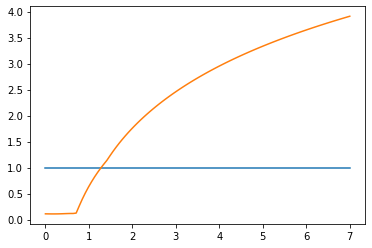

In [21]:
xxx = np.linspace(0, 7, 100)
plt.plot(xxx, [1 for x in xxx], xxx, [u_approx(x) for x in xxx])

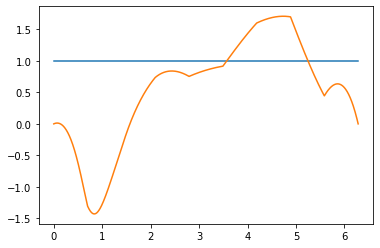

In [22]:
ffff = lambda tau: psi1_approx(tau)*K1([1,1], tau)/LA.norm(dx1(tau))

xxx = np.linspace(0, 2*np.pi, 1000)
plt.plot(xxx, [1 for x in xxx], xxx, [ffff(x) for x in xxx])

In [23]:
# TODO перевірити базис Гамма